# Exoplanetary Systems

<a id='table_of_contents'></a>

## Table of Contents
1. [Acknowledgements](#acknowledgements)
2. [Abstract](#abstract)
3. [Imports](#imports)
4. [Tap requests](#tap_requests)
    - [.schema request](#stellar_hosts_tap_schema)
    - [stellar hosts database request](#stellar_hosts_tap_db)
5. [Data Cleaning](#data_cleaning)
6. [Creating Dataframes](#creating_dataframes)
7. [Plots](#plots)
    - [plot settings](#plot_settings)
    - [Pie Chart: Systems Where Exoplanets Most Commonly Occur](#pie_sys_exoplanet_occurance)
    - [Nested Bar Chart: Exoplanet Systems by Star Count](#bar_exosys_by_star)
    - [Pie Figure: Most Common Exoplanet Systems](#most_common_exoplanet_systems)
8. [Conclusion](#conclusion)

<a id='acknowledgements'></a>

## Acknowledgements
All data is gathered from NASA's 'Stellar Hosts' database
    DOI: 10.26133/NEA40
    
[return to top](#table_of_contents)

<a id='abstract'></a>

## Abstract
[return to top](#table_of_contents)

### Structure
This program is intended to get star system data from NASA's 'stellar hosts' database via TAP request using SQL. Then the data is organised and cleaned down to the unique star systems required ready for anaylasis. The data is then organised into new dataframes for the use of various plots...
### Plots
There are three plots of data

#### 1. Systems Where Exoplanets Most Commonly Occur:
[chart](#pie_sys_exoplanet_occurance)

Intent:
> A pie chart representation of what type of systems exoplanets most commonly occur into relation to how many stars are within the system.

Contents: 
- Figure
    - Pie chart - *represents data of what systems exoplanets most commonly occur in, related to how many stars are in the system.*
    - Legend - *displays how many stars are in each system on the pie chart related by color.*
    - Additional exoplanet discovery data - *extra data displayed on the figure represents how many confirmed exoplanet systems have been discovered as well as individual exoplanets.*

#### 2. Exoplanet Systems by Star Count:
[chart](#bar_exosys_by_star)

Intent:
> A figure containing two nested bar charts that represent all observations of exoplanet systems, nested by how many exoplanets occur in each system and organised by how many stars are in the system. This is intended to show the frequency in which exoplanets/multiplanetary systems occur in relation to sigular star and binary star systems.
>
> The same data is shown in two formats: scale and log. 'Scale' helps visualise the actual occurance of exoplantery systems where as, 'log' is intended to help visualise small frequencies. 

Contents: 
- Figure
    - Nested bar chart - *represents all observations of exoplanet systems, nested by how many exoplanets occur in each system and organised by how many stars are in the system.*
    - Nested bar chart LOG - *represents the same data as above but in a log format to help visualise small data*

#### 3. Most Common Exoplanet Systems:
[chart](#most_common_exoplanet_systems)

Intent:
> A collection of pie charts which are independant of one another, each corrosponding to a type of star/binary star system. Each pie chart represents which is the most common types of exoplanet systems in relation to the star system.
>
> [!NOTE]
> These pie charts do not inculde any exoplanet systems that would fall in less than 1% of the overall data (this is to prevent small data crowding the data: as this is a visual generalisation)
>
> Additionally note that data that falls in less than the 1% is completely left out of the data.


Contents: 
- Figure
    - Pie charts - *Each pie chart represents which is the most common types of exoplanet systems in relation to it's systems star count*
    - Legend - *The legend visualises the planet count by color and applies to all pie charts*

[return to top](#table_of_contents)


<a id='imports'></a>

## Imports
- Astroquery.utils.tap.core's, TapPlus - required to make Tap requests to NASA's astronomical database to get the 'Stellar Hosts' table
- IO's, StringIO - to format the Tap VOTable result in a tempory file so it can be read by pandas .readcsv() and converted into a pandas database and optionally saved as a .csv file
- Mathplotlib's, pylot (plt) - to create visual plots for the data
- Numpy (np) - to work with the pandas dataframe
- Pandas (pd) - create pandas databases and dataframes

[return to top](#table_of_contents)

In [68]:
from astroquery.utils.tap.core import TapPlus
from io import StringIO
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd

<a id='tap_requests'></a>

## Tap requests

##### Request types:
<a id='tap_synchronous'></a>
- **Synchronous** - Request type for small sets of data

<a id='tap_asynchronous'></a>
- **Asynchronous** - Request type for large sets of data *(else all of the data will not be downloaded)*

##### Request Method:
1. **tap_service** - A created class instance of TapPlus with the desired url to later query

2. **Query** - The SQL query desired to make to the tap_service

3. **job** - The result of running the query on the tap_service

4. **results_csv** - .csv file formated results, converted from the default returned VOTable format

5. **'dataframe_name'** - Converted .csv file results to a Panda's dataframe

6. **.csv_file** - (Optional) save the dataframe as a .csv for visualisation



<a id='stellar_hosts_tap_schema'></a>

### .schema request

A [synchronous](#tap_synchronous) Tap request method carried out on NASA's exoplanet archive, to get the schema of the 'Stellar Hosts' table.

The 'Stellar Hosts' table is very complex as it has over 100 columns of data. For this reason the database is saved as a .csv file where the schema column descriptions can be read and decide what data is required for this program

>[!NOTE] This process is optional and only need be carried out once to save the 'Stellar Hosts' schema as a .csv file and is not required for the program itself

[return to top](#table_of_contents)

In [ ]:
# check the schema of the data, as there are 134 columns I've saved the data as a csv file for easier referal/reading to see what data I would like to work with
tap_service = TapPlus(url="https://exoplanetarchive.ipac.caltech.edu/TAP")
query = "SELECT * FROM TAP_SCHEMA.columns WHERE table_name LIKE 'stellarhosts'"
job = tap_service.launch_job_async(query)

result_csv = job.get_results().to_pandas().to_csv(index=False)
stellar_hosts_schema = pd.read_csv(StringIO(result_csv))
stellar_hosts_schema.to_csv('stellar_hosts_schema.csv', index=False)
print(f"result csv: {stellar_hosts_schema}")

<a id='stellar_hosts_tap_db'></a>

### Stellar Hosts request

A [asynchronous](#tap_asynchronous) Tap request method carried out on NASA's exoplanet archive, to get the desired columns of data from the 'Stellar Hosts' database.

Used to save the desired column data from the stellar hosts VOTable file data into a tempory csv format to convert to a Pandas database.

#### Requested data

The columns 'sy_name', 'sy_snum' and 'sy_pnum' have been taken from the 'Stellar Hosts' database
- sy_name - system name: used to remove duplicate systems from the database as we are intreseted in system data and do not want duplicates
- sy_snum - system star number: used to see how many stars are within the individual systems
- sy_pnum -  system planet number: used to see how many planets are within the individual systems

>[!NOTE] The 'Stellar Hosts' database has data on stellar hosts, which means there are multiple references to the same system and this program focuses on systems alone

[return to top](#table_of_contents)

In [ ]:
# make spefic query for the specific columns wanted 
tap_service = TapPlus(url="https://exoplanetarchive.ipac.caltech.edu/TAP")
query = "SELECT sy_name, sy_snum, sy_pnum FROM stellarhosts"
job = tap_service.launch_job_async(query)

# save stellar_hosts as dataframe and file for reference 
result_csv = job.get_results().to_pandas().to_csv(index=False)
stellar_hosts = pd.read_csv(StringIO(result_csv))

<a id='data_cleaning'></a>

## Data cleaning

#### Steps
- **[Order](#order)** - Sorted alphabetically *(personal choice)*
- **[Check](#check)** - Look over the gathered data for required cleaning
    - Row count of data gathered
    - Duplicate data: returning count of duplicates and non-duplicates by 'system name' **(sy_name)*
    - Null values: looks for any null data over the database   
- **[Clean](#clean)** - Drop duplicate systems from database by 'sy_name'
- **[Save](#save)** - *(optional)* Save database as .csv file for visual reference

[return to top](#table_of_contents)

<a id='order'></a>

### Order

In [71]:
stellar_hosts = stellar_hosts.sort_values(by=['sy_name'])

<a id='check'></a>

### Check

In [ ]:
# counts how many rows of data there are
print(f"Rows in data: {stellar_hosts.sy_name.count().sum()}\n")

# look over the data dase by the system names and see if there are duplicate columns
duplicates = stellar_hosts.duplicated(subset=['sy_name'], keep='first')

# as duplicates is a boolean series running .sum() will count every True value as Trues will be 1 and False's will be 0.
print(f"Number of non-duplicate systems: {stellar_hosts.sy_name.count().sum() - duplicates.sum()}")
print(f"Number of duplicate systems: {duplicates.sum()}")
# check if any data has null values
print(f"Columns with null values:\n{stellar_hosts.isnull().sum()}")

<a id='clean'></a>

### Clean

>[!NOTE] After cleaning re-run [check](#check)

In [73]:
stellar_hosts = stellar_hosts.drop_duplicates()
# re-run cell above to check drop has worked as expected

<a id='save'></a>

### Save

In [74]:
stellar_hosts.to_csv('stellar_hosts.csv', index=False)

<a id='creating_dataframes'></a>

## Creating dataframes

### dataframes
- **system_df:** 
    - A large pandas dataframe containing all systems/binary system names, star number and planet number within the system.   

- **star_srs:**
    - A small pandas series with the 'system star count' as the index and the occurance that exoplanets have been observered in the system type *(not all exoplanets - the occurance of a system containing exoplanets)*.

- **planet_to_star_df:**
    - A small pandas dataframe with the 'system star count' as the index and divided into additional 'exoplanet count' columns by system, data relates to observed occurances.

[return to top](#table_of_contents)

In [ ]:
# create pandas dataframe 
system_df = pd.DataFrame(stellar_hosts)
print(system_df)

In [ ]:
# group df by sy_snum size all instances of the same star count are combined
# this allows us to see the occurance of systems that contain any amount of planets
star_srs = system_df.groupby('sy_snum').size()
# see the series
print(star_srs)
# see series index values
print(star_srs.index.values)
# see sum of data
print(star_srs.sum())

In [ ]:
#df when grouping by sy_snum and sy_pnum by size() and unstacked(make missing data == 0 for table)
planet_to_star_df = system_df.groupby(['sy_snum', 'sy_pnum']).size().unstack(fill_value=0)

# see visual dataframe representation
print(planet_to_star_df)

<a id='plots'></a>

## Plots

<a id='plot_settings'></a>

### plot settings

Defined colour swatches that can be applied to the plots.

[return to top](#table_of_contents)

In [96]:
text_colour = '#581845'
# colour map with id's for correct allocation
planet_color_map = {
    1: '#519DE9',
    2: '#7CC674',
    3: '#73C5C5',
    4: '#8481DD',
    5: '#F6D173',
    6: '#EF9234',
    7: '#A30000',
    8: '#D2D2D2'
}

# incase planet colors are wanted without mapping
planet_colors = planet_color_map.values()

star_colors = [
    '#F4C145',
    '#EC7A08',
    '#A30000',
    '#470000'
]


<a id='pie_sys_exoplanet_occurance'></a>

### Pie Chart: Systems Where Exoplanets Most Commonly Occur

A pie chart representation of what type of systems exoplanets most commonly occur into relation to how many stars are within the system.

[return to top](#table_of_contents)

[return to abstract](#abstract)

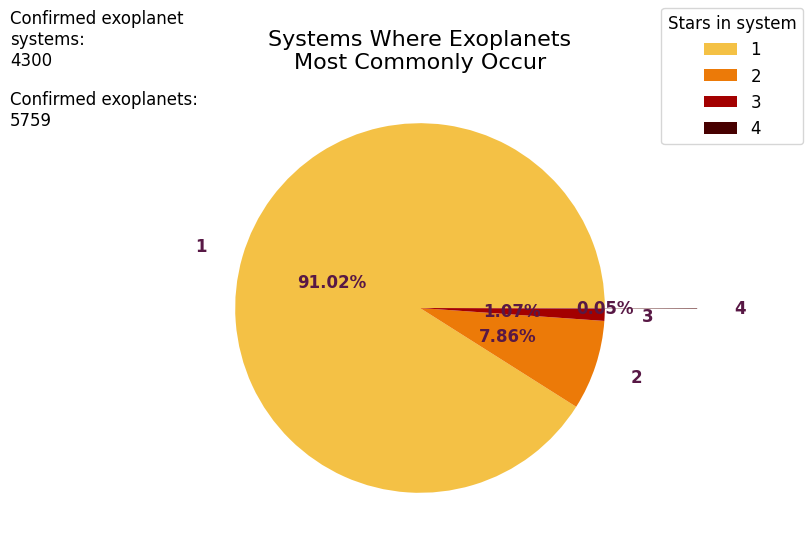

In [120]:
# create figure for chart and text to display on
fig, ax = plt.subplots(figsize=(8, 6))
# Array of the dataframe index == star count for the legend
labels = star_srs.index.values
# explode hard to see data
explode = (0, 0, 0, 0.5)

# create pie chart
ax.pie(
    star_srs, 
    colors=star_colors, 
    explode=explode, 
    labels=labels, 
    autopct='%1.2f%%', 
    pctdistance=0.5, 
    labeldistance=1.2, 
    textprops={
        'size' : 'large',
        'color': '#581845',
        'weight': 'bold'}
)

# plt_title = "Star systems where\nexoplanets most commonly occur"
plt_title = "Systems Where Exoplanets\nMost Commonly Occur"
ax.set_title(
    plt_title,
    fontsize=16
    )

# allow legend to be set to fig not ax
fig.legend(
    labels, 
    title="Stars in system", 
    title_fontsize=12,
    loc=1,
    fontsize=12
    )

# print count of rows from cleaned data as it will match systems with confirmed exoplanets
text1 = f"Confirmed exoplanet\nsystems:\n{system_df['sy_pnum'].count()}"
# print sum of system planets column as all values will match the total amount of exoplanets 
text2 = f"Confirmed exoplanets:\n{system_df['sy_pnum'].sum()}"
fig.text(0, 0.9, text1, size=12)
fig.text(0, 0.8, text2, size=12)

fig.savefig("systems_where_explanets_most_commonly_occur.png")
plt.show()

<a id='bar_exosys_by_star'></a>

### Nested Bar Chart: Exoplanet Systems by Star Count

A figure containing two nested bar charts that represent all observations of exoplanet systems, nested by how many exoplanets occur in each system and organised by how many stars are in the system. This is intended to show the frequency in which exoplanets/multiplanetary systems occur in relation to sigular star and binary star systems.

> The same data is shown in two formats: scale and log. 'Scale' helps visualise the actual occurance of exoplantery systems where as, 'log' is intended to help visualise small frequencies.

[return to top](#table_of_contents)

[return to abstract](#abstract)

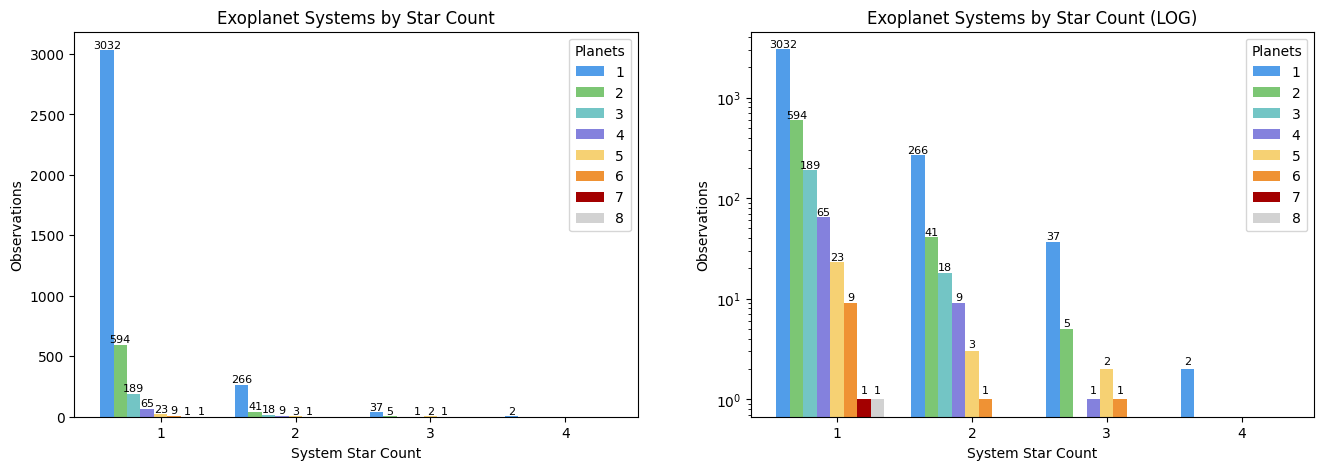

In [98]:
# create a figure that contains 2 plots 
fig, ax = plt.subplots(1, 2, figsize=(16, 5))

bar_width = 0.1
# returns [0, 1, 2, 3]
indices = np.arange(len(planet_to_star_df))

# for both plts (as they are the same in exception of 1 being log)
i = 0
while i < 2:
    # j = 0, sy_pnum_val = j+1
    for j, sy_pnum_val in enumerate(planet_to_star_df.columns):
        # label = creates the planets 1-8 side labels legend
        bars = ax[i].bar(
            x=indices + j * bar_width,
            height=planet_to_star_df[sy_pnum_val],
            width=bar_width,
            label=f'{sy_pnum_val}',
            color=planet_color_map[sy_pnum_val]
        )

        # print observation values atop the bars
        for bar in bars:
            yval = bar.get_height()
            if yval > 0:
                ax[i].text(
                    bar.get_x() + bar.get_width()/2,
                    yval + 0.1, int(yval),
                    ha='center',
                    va='bottom',
                    fontsize=8,
                )
    
    ax[i].set_xlabel('System Star Count')
    ax[i].set_ylabel('Observations')
    ax[i].set_xticks(indices + bar_width * 4)
    ax[i].set_xticklabels(planet_to_star_df.index)
    ax[i].legend(title='Planets')
    i += 1

ax[0].set_title('Exoplanet Systems by Star Count')

# for visualisation of smaller data
ax[1].set_yscale('log')
ax[1].set_title('Exoplanet Systems by Star Count (LOG)')

plt.show()

<a id='most_common_exoplanet_systems'></a>

### Pie Figure: Most Common Exoplanet Systems

A collection of pie charts which are independant of one another, each corrosponding to a type of star/binary star system. Each pie chart represents which is the most common types of exoplanet systems in relation to the star system.

[return to top](#table_of_contents)

[return to abstract](#abstract)

Text(0.51, 0.9, '(excluding Exoplanet Systems falling under 1%)')

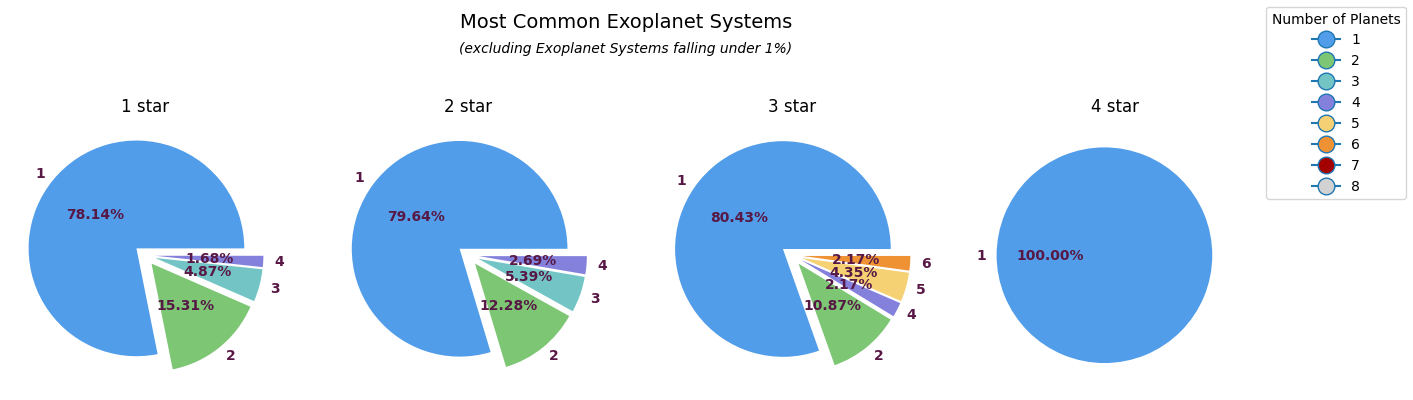

In [99]:
# assign axes to automate axes columns for charts
axes = len(planet_to_star_df)
fig, ax = plt.subplots(1, axes, figsize=(16, 5))
# get planets in system counts as a list
fig_labels = planet_to_star_df.iloc[0].index.values

# generate each ax automatically on star count
i = 0
while i < axes:
    # get row of data from grouped (this will be in relation to star)
    star_system = planet_to_star_df.iloc[i]
    # calculate what the 1% value is to leave off the pie chart (small data)
    # we will represent this data in the log bar chart
    less_1_percent = 0.01 * star_system.sum()
    # drop all planet counts that are less than the 1% 
    # from the data we want to display
    star_system = star_system[star_system > less_1_percent]
    # get labels == planet count
    lables = star_system.index.values
    # explode wedges by data count
    explode = [0.1] * len(lables)
    # create a color map with only the labels in current data
    colors = [planet_color_map[label] for label in star_system.index if label in planet_color_map]

    ax[i].pie(
        star_system,
        labels=lables,
        colors=colors,
        autopct=lambda pct: '{:1.2f}%'.format(pct) if pct > 1 else'',
        pctdistance=0.5,
        explode=explode,
        textprops={'color': text_colour, 'weight': 'bold'}
    )
    
    # systems_df.name makes sure that the right star count if printed out if there 
    # was a missing star count i.e no 5 star systems but there was a 6 star system
    ax[i].set_title(
        f"{star_system.name} star",
    )
    i += 1

# ChatGPT wrote this for me as I couldn't find/understand the handles documentation
handles = [
    plt.Line2D([0], [0],
    marker='o',
    markerfacecolor=planet_color_map[label],
    markersize=12) for label in planet_color_map.keys()
]

# create legend with corrosponding colours for 
# planet counts and colours
fig.legend(
    handles,
    planet_color_map.keys(),
    title="Number of Planets",
    loc=1,
)

fig_title = "Most Common Exoplanet Systems"
fig_under_title = "(excluding Exoplanet Systems falling under 1%)"
fig.text(0.51, 0.95, fig_title, size=14, horizontalalignment='center')
fig.text(0.51, 0.9, fig_under_title, size=10, horizontalalignment='center', fontstyle='italic')

<a id='conclusion'></a>

## Conclusion

This is my conclusion...

[return to top](#table_of_contents)